In [1]:
import tensorflow as tf
from tensorflow import keras

/almac/paquetes/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/almac/paquetes/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/almac/paquetes/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/almac/paquetes/anaconda3/lib/python3.7/site-packages/tensorflow/python/f

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
def conv_block(input_tensor, num_filters):
    x = keras.layers.Conv2D(num_filters, 3, padding="same")(input_tensor)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    x = keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    return x

def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = keras.layers.MaxPool2D( (2,2) )(x)

    return x, p

def decoder_block(input_tensor, skip_features, num_filters):
    x = keras.layers.Conv2DTranspose( num_filters, (2,2), strides=2, padding="same")(input_tensor)
    x = keras.layers.Concatenate()( [x, skip_features] )
    x = conv_block(x, num_filters)

    return x

def build_unet(input_shape):
    inputs = keras.layers.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = tf.keras.models.Model(inputs, outputs, name="U-NET")

    return model

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
IMG_SIZE = 512
B_SIZE = 1

In [6]:
datagen = ImageDataGenerator(
    rescale = 1./255,
)

In [7]:
train_imgs_gen = datagen.flow_from_directory(
    'workdata/train/',
    target_size = (IMG_SIZE,IMG_SIZE),
    color_mode = 'rgb',
    batch_size = B_SIZE,
    class_mode = None,
    seed = 1,
    shuffle = True,
    classes = ['imgs']
)

Found 5472 images belonging to 1 classes.


In [8]:
train_mask_gen = datagen.flow_from_directory(
    'workdata/train/',
    target_size = (IMG_SIZE,IMG_SIZE),
    color_mode = 'grayscale',
    batch_size = B_SIZE,
    class_mode = None,
    seed = 1,
    shuffle = True,
    classes = ['mask']
)

Found 5472 images belonging to 1 classes.


In [9]:
val_imgs_generator = datagen.flow_from_directory(
    'workdata/validation/',
    target_size = (IMG_SIZE,IMG_SIZE),
    color_mode = 'rgb',
    batch_size = B_SIZE,
    class_mode = None,
    seed = 1,
    shuffle = True,
    classes = ['imgs']
)

Found 40 images belonging to 1 classes.


In [10]:
val_mask_generator = datagen.flow_from_directory(
    'workdata/validation/',
    target_size = (IMG_SIZE,IMG_SIZE),
    color_mode = 'grayscale',
    batch_size = B_SIZE,
    class_mode = None,
    seed = 1,
    shuffle = True,
    classes = ['mask']
)

Found 40 images belonging to 1 classes.


In [11]:
train_generator = (pair for pair in zip(train_imgs_gen, train_mask_gen))
val_generator = (pair for pair in zip(val_imgs_generator, val_mask_generator))

In [12]:
def dice_coefficient_t(mask, predicted_mask, t=0.5):
    mask = tf.cast(mask > 0.5, dtype=tf.float32)  # Apply threshold and convert to float32
    predicted_mask = tf.cast(predicted_mask > t, dtype=tf.float32)  # Apply threshold and convert to float32

    intersection = tf.reduce_sum(tf.cast(tf.logical_and(tf.cast(mask, dtype=tf.bool), tf.cast(predicted_mask, dtype=tf.bool)), dtype=tf.float32))
    intersection_area = tf.reduce_sum(intersection)

    mask_area = tf.reduce_sum(mask)
    predicted_mask_area = tf.reduce_sum(predicted_mask)

    dice = (2.0 * intersection_area) / (mask_area + predicted_mask_area)
    return dice

def ev_dice(mask, predicted_mask, t=0.5):

    dice = dice_coefficient_t(mask, predicted_mask, t=t)

    with tf.Session() as sess:
        dice_value = sess.run(dice)
    return dice_value

In [13]:
def jaccard_coefficient_t(mask, predicted_mask, t=0.5):
    mask = tf.cast(mask, dtype=tf.float32)
    predicted_mask = tf.cast(predicted_mask > t, dtype=tf.float32)

    intersection = tf.reduce_sum(tf.cast(tf.logical_and(tf.cast(mask, dtype=tf.bool), tf.cast(predicted_mask, dtype=tf.bool)), dtype=tf.float32))
    intersection_area = tf.reduce_sum(intersection)

    union = tf.reduce_sum(tf.cast(tf.logical_or(tf.cast(mask, dtype=tf.bool), tf.cast(predicted_mask, dtype=tf.bool)), dtype=tf.float32))
    union_area = tf.reduce_sum(union)

    jaccard = intersection_area / union_area
    return jaccard

def ev_jaccard(mask, predicted_mask, t=0.5):

    jaccard = jaccard_coefficient_t(mask, predicted_mask, t=t)

    with tf.Session() as sess:
        jaccard_value = sess.run(jaccard)
    return jaccard_value

In [14]:
input_shape = (IMG_SIZE , IMG_SIZE , 3)

model = build_unet(input_shape)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[dice_coefficient_t, jaccard_coefficient_t])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "U-NET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 64) 256         conv2d[0][0]                     
________________________________________________________________________________

Expected 16 hours using b_size 1, IMG_SIZE 512, steppe = 6012

In [15]:
from tensorflow.keras.callbacks import CSVLogger

csv_logger_callback = CSVLogger('training_history.csv')

In [16]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint.h5',  # Path to save the checkpoints
    save_best_only=True,  # Save only the best model based on a monitored metric
    monitor='dice_coefficient',  # Metric to monitor for saving the best model
    mode='max'  # 'min' or 'max' depending on the monitored metric
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs'  # Directory to store TensorBoard logs
)

In [17]:
history = model.fit_generator(
    train_generator,
    epochs=4,
    steps_per_epoch=4,
    validation_data=val_generator,
    validation_steps=10,
    callbacks=[csv_logger_callback, checkpoint_callback, tensorboard_callback]
)

#model.fit_generator(train_generator, epochs=10, steps_per_epoch=1503)

Epoch 1/4
4/4 [==============================] - 22s 5s/step - loss: 0.5944 - dice_coefficient_t: 0.0032 - jaccard_coefficient_t: 0.0016 - val_loss: 0.7223 - val_dice_coefficient_t: 0.0066 - val_jaccard_coefficient_t: 0.0033
Epoch 2/4
4/4 [==============================] - 7s 2s/step - loss: 0.3381 - dice_coefficient_t: 0.0152 - jaccard_coefficient_t: 0.0077 - val_loss: 3.6035 - val_dice_coefficient_t: 0.0067 - val_jaccard_coefficient_t: 0.0034
Epoch 3/4
4/4 [==============================] - 7s 2s/step - loss: 0.2336 - dice_coefficient_t: 0.0000e+00 - jaccard_coefficient_t: 0.0000e+00 - val_loss: 3.7631 - val_dice_coefficient_t: 0.0069 - val_jaccard_coefficient_t: 0.0035
Epoch 4/4
4/4 [==============================] - 7s 2s/step - loss: 0.1859 - dice_coefficient_t: 0.0061 - jaccard_coefficient_t: 0.0031 - val_loss: 183.8759 - val_dice_coefficient_t: 0.0066 - val_jaccard_coefficient_t: 0.0033


In [18]:
X, y = next(train_generator)
predicted = model.predict(X)

In [19]:
model

In [20]:
import matplotlib.pyplot as plt

In [21]:
def compare3(img0, img1, img2):
    fig, ax = plt.subplots(1, 3, figsize=(15,8))
    ax[0].imshow(img0)
    ax[0].axis("off")
    ax[1].imshow(np.squeeze(img1))
    ax[1].axis("off")
    ax[2].imshow(np.squeeze(img2))
    ax[2].axis("off")
    plt.show()

NameError: name 'np' is not defined

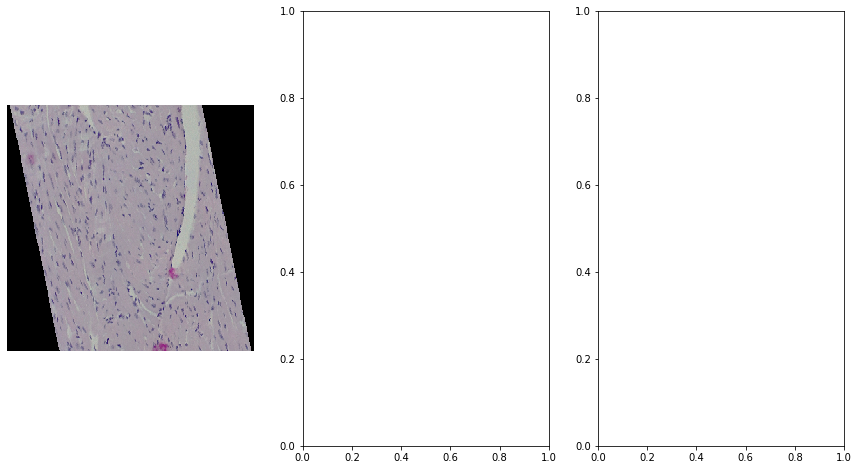

In [22]:
for i in range(len(X)):
    compare3(X[i], y[i], predicted[i])
    print(i, np.max(predicted), predicted.shape)